<a href="https://colab.research.google.com/github/ChiShengChen/test/blob/master/RNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!gdown --id '1_A8htJt-nOKjBegV-BUrlm_sVa2l9QxE' --output heart_sound.zip
!unzip heart_sound.zip

Downloading...
From: https://drive.google.com/uc?id=1_A8htJt-nOKjBegV-BUrlm_sVa2l9QxE
To: /content/heart_sound.zip
115MB [00:00, 119MB/s]
Archive:  heart_sound.zip
  inflating: set_a.csv               
  inflating: set_a/Aunlabelledtest__201012172010.wav  
  inflating: set_a/Aunlabelledtest__201101051105.wav  
  inflating: set_a/Aunlabelledtest__201101061552.wav  
  inflating: set_a/Aunlabelledtest__201101091156.wav  
  inflating: set_a/Aunlabelledtest__201101110659.wav  
  inflating: set_a/Aunlabelledtest__201101152256.wav  
  inflating: set_a/Aunlabelledtest__201101220549.wav  
  inflating: set_a/Aunlabelledtest__201101241434.wav  
  inflating: set_a/Aunlabelledtest__201102081033.wav  
  inflating: set_a/Aunlabelledtest__201102081045.wav  
  inflating: set_a/Aunlabelledtest__201102200848.wav  
  inflating: set_a/Aunlabelledtest__201103011036.wav  
  inflating: set_a/Aunlabelledtest__201103140236.wav  
  inflating: set_a/Aunlabelledtest__201103170122.wav  
  inflating: set_a/Aunlabell

In [0]:
!ls 

heart_sound.zip  set_a	    set_a_timing.csv  set_b.csv
sample_data	 set_a.csv  set_b


Data from: https://www.kaggle.com/kinguistics/heartbeat-sounds

Reference: https://www.kaggle.com/mychen76/heart-sounds-analysis-and-classification-with-lstm/notebook

In [0]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import time
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

### Explorer data  
The audio files are of varying lengths, between 1 second and 30 seconds (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

Most information in heart sounds is contained in the low frequency components, with noise in the higher frequencies.

### Normal case
 A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” 

In [0]:
import IPython.display as ipd

In [0]:
normal_file="set_a/normal__201106111136.wav"
ipd.Audio(normal_file) 

### Murmur case
Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”.

In [0]:
murmur_file='set_a/murmur__201108222231.wav'
ipd.Audio(murmur_file) 

### Extrasystole case
Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases.

In [0]:
extrastole_file="set_b/extrastole__127_1306764300147_C2.wav"
ipd.Audio(extrastole_file) 

### Artifact case
In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise.

In [0]:
artifact_file="set_a/artifact__201012172012.wav"
ipd.Audio(artifact_file) 

### Preprocess
Use python package librosa to load wav file

Use Mel Frequency Cepstral Coefficient (MFCC) as acoustic features

In [0]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            # print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            # print(X.shape)
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                # print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, input_length) 
                               
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
            mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T 
                     
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        # feature = np.array(mfccs).reshape([-1,1])
        feature = mfccs
        if feature.shape[0] != 376:
            continue
        data.append(feature)
    return data

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal','Extrasystole']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2, 'Extrasystole': 3}
 
{0: 'artifact', 1: 'murmur', 2: 'normal', 3: 'Extrasystole'}


In [0]:
import os, fnmatch

A_folder='set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir('set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir('set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir('set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [3 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir('set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
# A_unlabelledtest_files = fnmatch.filter(os.listdir('set_a'), 'Aunlabelledtest*.wav')
# A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
# A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

loaded dataset-a


In [0]:
B_folder='set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir('set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir('set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_sounds]

B_extrastole_files = fnmatch.filter(os.listdir('set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [3 for items in B_extrastole_sounds]

#test files
# B_unlabelledtest_files = fnmatch.filter(os.listdir('set_b'), 'Bunlabelledtest*.wav')
# B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
# B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

loaded dataset-b


In [0]:
print(len(A_artifact_sounds))
print(len(A_normal_sounds)+len(B_normal_sounds))
print(len(A_extrahls_sounds)+len(B_extrastole_sounds))
print(len(A_murmur_sounds)+len(B_murmur_sounds))

40
347
64
125


In [0]:
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

print ("combined training data record: ",len(y_data))

combined training data record:  576


In [0]:

print(x_data.shape)

(576, 376, 40)


In [0]:
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.2.0
keras version:  2.3.1


Using TensorFlow backend.


In [0]:
seed = 100
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)


In [0]:
y_test

array([2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 3, 2, 3, 2, 1, 2, 2, 3, 2, 1, 3, 2,
       1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2,
       3, 2, 1, 3, 2, 2, 0, 3, 1, 0, 3, 2, 2, 1])

In [0]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (576,)
data size of the array: : 576
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  4608
0

audio data shape:  (576, 376, 40)
data size of the array: : 8663040
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  69304320

training data shape:  (466, 376, 40)
training label shape:  (466,)

validation data shape:  (52, 376, 40)
validation label shape:  (52,)

test data shape:  (58, 376, 40)
test label shape:  (58,)


In [0]:
class heart_sound_dataset(Dataset):
    def __init__(self, feature, label):
        self.feature = torch.Tensor(feature)
        self.label = label
        if label is not None:
            self.label = torch.LongTensor(label)
    def __len__(self):
        return self.feature.shape[0]
    def __getitem__(self, index):
        feature = self.feature[index]
        label = self.label[index]
        return feature, label

In [0]:
batch_size = 32
train_dataset = heart_sound_dataset(x_train, y_train)
val_dataset = heart_sound_dataset(x_val, y_val)
test_dataset = heart_sound_dataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = 1

        self.lstm = nn.LSTM(input_size, hidden_size,
                           num_layers=self.num_layers,
                           bidirectional=True, batch_first=True)

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size*2, 4),
        )

        

    def forward(self, input):
        output, (hidden, c) = self.lstm (input)

        a,b, = hidden[0], hidden[1]
        hidden = torch.cat((a,b),1)
        # print(hidden.shape)
        label = self.fc1(hidden.squeeze())
        return label

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RNN(input_size=40, hidden_size=256, batch_size=32)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [0]:
num_epoch = 30

train_epoch_loss = []
train_acc = []
val_epoch_loss = []
val_acc = []
best_acc = 0.0

for epoch in range(num_epoch):
    model.train()
    correct = 0
    train_loss = []

    for batch_idx, (img, label) in enumerate(train_loader):
        # feed image to model
        img, label = img.to(device), label.to(device)
        output = model(img)
        
        # update model parametres
        optimizer.zero_grad()
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        
        # get predict result 
        predict = torch.max(output, 1)[1]
        correct += (label == predict).cpu().numpy().sum()

        
        # record training process
        train_loss.append(loss.item())
        
        if (batch_idx+1) % 50 == 0:
            print('Train Epoch: {:0>2d} [{:0>5d}/{:0>5d} ({:.0f}%)]     Loss: {:.6f}\r'.format(
                    epoch+1, batch_idx * batch_size, len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
    print("Train Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), correct/len(train_dataset)))
    train_epoch_loss.append(np.mean(train_loss))
    train_acc.append(correct/len(train_dataset))

    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_loss = []
        for batch_idx, (img, label) in enumerate(val_loader):
            
            img, label = img.to(device), label.to(device)
            output = model(img)
            
            loss = F.cross_entropy(output, label)
            val_loss.append(loss.item())
            
            predict = torch.max(output, 1)[1]
            val_correct += (label == predict).cpu().numpy().sum()
    print("Test Epoch: {}, test Loss: {:.4f}, test Acc: {:.4f}".format(epoch + 1, np.mean(val_loss), val_correct/len(val_dataset)))
    val_epoch_loss.append(np.mean(val_loss))
    val_acc.append(val_correct/len(val_dataset))  

    if val_correct/len(val_dataset) > best_acc:
        best_acc = val_correct/len(val_dataset)
        model_path = 'best.pth'
        torch.save(model.state_dict(), model_path)
        print('Get new best validation result: {}, save model to: {}'.format(best_acc, model_path))
    # To be add : split train into train and valid ,save best model, test result and draw confusion matrix

Train Epoch: 1, train Loss: 1.2884, train Acc: 0.3648
Test Epoch: 1, test Loss: 1.0940, test Acc: 0.6731
Get new best validation result: 0.6730769230769231, save model to: best.pth
Train Epoch: 2, train Loss: 1.1258, train Acc: 0.5966
Test Epoch: 2, test Loss: 0.9160, test Acc: 0.7500
Get new best validation result: 0.75, save model to: best.pth
Train Epoch: 3, train Loss: 1.0435, train Acc: 0.5923
Test Epoch: 3, test Loss: 0.8121, test Acc: 0.7500
Train Epoch: 4, train Loss: 1.0003, train Acc: 0.5923
Test Epoch: 4, test Loss: 0.7599, test Acc: 0.7500
Train Epoch: 5, train Loss: 0.9720, train Acc: 0.5966
Test Epoch: 5, test Loss: 0.7444, test Acc: 0.7692
Get new best validation result: 0.7692307692307693, save model to: best.pth
Train Epoch: 6, train Loss: 0.9522, train Acc: 0.6030
Test Epoch: 6, test Loss: 0.7333, test Acc: 0.7692
Train Epoch: 7, train Loss: 0.9253, train Acc: 0.6373
Test Epoch: 7, test Loss: 0.7344, test Acc: 0.7500
Train Epoch: 8, train Loss: 0.9092, train Acc: 0.64

In [0]:
best_model = RNN(input_size=40, hidden_size=256, batch_size=32)
best_model.load_state_dict(torch.load('best.pth'))
best_model = model.to(device)
best_model.eval()
test_correct = 0
predict_y = []
with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        img, label = img.to(device), label.to(device)
        output = best_model(img)
            
        predict = torch.max(output, 1)[1]
        predict_y += predict.detach().cpu()
        
        test_correct += (label == predict).cpu().numpy().sum()
    test_acc = test_correct/len(test_dataset)

predict_y = np.array(predict_y)
print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.7241


Text(0, 0.5, 'loss')

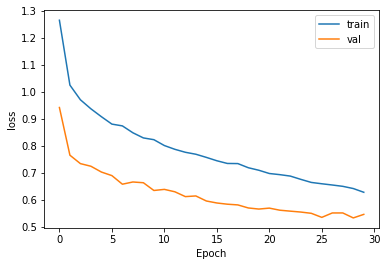

In [0]:
plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)
plt.legend(['train', 'val'])
plt.xlabel("Epoch")
plt.ylabel("loss")

Text(0, 0.5, 'Accuracy')

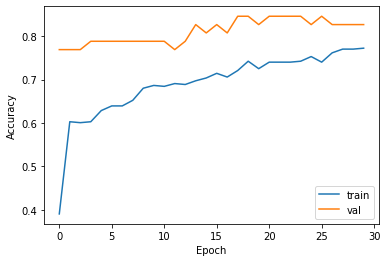

In [0]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    #plt.figure(12,12)
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.savefig('confuse.jpg')
    return ax

Normalized confusion matrix
[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.53333333 0.46666667 0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]]


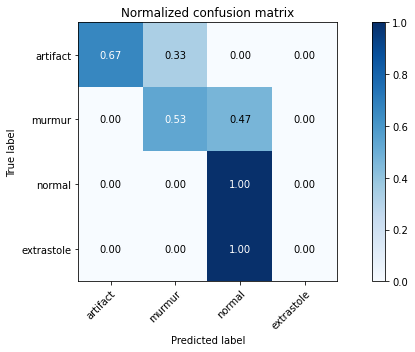

In [0]:
sound_class = ['artifact','murmur','normal','extrastole']
plot_confusion_matrix(y_test, predict_y, classes=sound_class, normalize=True,
                      title='Normalized confusion matrix')